In [4]:
from citalopram_project.load import load_spikes, load_neurons, load_events
import pandas as pd
from citalopram_project.compose import Pipeline
from spiketimes.df.binning import binned_spiketrain_bins_provided
from spiketimes.df.alignment import align_around_by
from spiketimes.df.statistics import mean_firing_rate_by
import numpy as np
from scipy.stats import zmap, zscore
import seaborn as sns
import matplotlib.pyplot as plt

neurons = load_neurons()
shock_spikes = load_spikes("base_shock").merge(neurons[["neuron_id", "cluster", "session_name", "group"]])
shock_events = load_events("base_shock")


In [5]:
post_shock_spikes = load_spikes("post_base_shock")

In [86]:
post_shock_spikes.merge()

,neuron_id,spike_time_samples,group_name,spiketimes
0,1069,-17989915,chronic_saline,-599.663833
1,1069,-17979263,chronic_saline,-599.308767
2,1069,-17951301,chronic_saline,-598.376700
3,1069,-17942067,chronic_saline,-598.068900
4,1069,-17932456,chronic_saline,-597.748533
...,...,...,...,...
2221978,2287,18482732,citalopram_discontinuation,616.091067
2221979,2287,18496422,citalopram_discontinuation,616.547400
2221980,2287,18523401,citalopram_discontinuation,617.446700
2221981,2287,18546910,citalopram_discontinuation,618.230333


In [94]:
def merge_connsecutive_sessions(df_current, df_next, df_neurons):
    df_neurons = df_neurons[["neuron_id", "cluster", "session_name", "group"]]
    df_current = df_current.merge(df_neurons)
    max_spikes = df_current.groupby(["neuron_id","session_name"], as_index=False).spiketimes.max().rename(columns={"spiketimes": "max_spike"})
    df_next = df_next.merge(max_spikes).assign(spiketimes=lambda x: x.spiketimes.add(x.max_spike)).loc[lambda x: x.spiketimes >= x.max_spike].drop("max_spike", axis=1).merge(df_neurons)
    return pd.concat([df_current, df_next])


In [3]:
neurons = load_neurons()
shock_spikes = load_spikes("base_shock").merge(neurons[["neuron_id", "cluster", "session_name", "group"]])
shock_events = load_events("base_shock")
post_shock_spikes = load_spikes("post_base_shock")

df_all = merge_connsecutive_sessions(shock_spikes, post_shock_spikes, neurons)

NameError: name 'load_neurons' is not defined

In [41]:
def align_spikes_to_events(df_data, df_events, t_before=None) -> pd.DataFrame:
    df = align_around_by(
    df_data=df_data,
    df_data_data_colname="spiketimes",
    df_data_group_colname="session_name", 
    df_events=df_events,
    df_events_event_colname="event_s", 
    df_events_group_colname="session_name", 
    t_before=t_before
    )
    return df

def rename(df, **column_mapping):
    return df.rename(columns=column_mapping)

def drop_cols(df, cols):
    return df.drop(cols, axis=1)

def dropna_rows(df):
    return df.dropna()

def bin_spikes(df, bin_width=0.01, t_before=-0.5, t_max=1.51, spikes_col="spiketimes"):
    bins = np.round(np.arange(t_before, t_max, bin_width), 3)
    return binned_spiketrain_bins_provided(df, 
                                bins=bins, 
                                spiketimes_col=spikes_col, 
                                spiketrain_col="neuron_id")

def exlude_using_spike_rate(df, min_rate, baseline_before=None):
    if baseline_before is not None:
        max_spike = baseline_before
    else:
        max_spike = df.spiketimes.max()
    idx = mean_firing_rate_by(df.loc[lambda x: x.spiketimes <= max_spike], spiketrain_col="neuron_id").loc[lambda x: x.mean_firing_rate > min_rate].neuron_id.values
    return df.loc[lambda x: x.neuron_id.isin(idx)]

def exclude_baseline(df, time_col, baseline_before=0, ):
    return df.loc[lambda x: x[time_col] >= baseline_before]

def pivot(df, time_col="time", neuron_col="neuron_id", value_col="values"):
    return pd.pivot(df, index=time_col, columns=neuron_col, values=value_col)

def standardize(df, baseline_before=None):
    def _standardize_col(col, baseline_before=None):
        if baseline_before is not None:
            return zmap(col, col.loc[lambda x: x.index < baseline_before])
        else:
            return zscore(col)
    return df.apply(_standardize_col, baseline_before=baseline_before)

def get_group_df(df, df_neurons, group):
    neurons = df_neurons.loc[lambda x: x.group == group].neuron_id.unique()
    return df[[c for c in df.columns if c in neurons]]

def counts_to_rate(df, bin_width, count_col="counts"):
    return df.assign(spike_rate = lambda x: x[count_col].divide(bin_width))

def gaussian_smooth(df, sigma):
    return df.apply(gaussian_filter1d, sigma=sigma)

def sort_by_activity_in_range(df, t_start, t_stop, agg_func):
    idx = df.loc[(df.index <= t_start) & (df.index <= t_stop)].apply(agg_func).sort_values(ascending=False).index.values
    return df[idx]


In [77]:
pipe = Pipeline([
    (exclude_baseline, dict(time_col="spiketimes", baseline_before=0)),
    (exlude_using_spike_rate, dict(min_rate=0.2)),
    (align_spikes_to_events, dict(df_events=shock_events, t_before=0.5)),
    (drop_cols, dict(cols=["spike_time_samples", "spiketimes"])),
    (rename, dict(aligned="spiketimes")),
    (bin_spikes, dict()),
    (pivot, dict(time_col="bin", value_col="counts")),
    (standardize, dict(baseline_before=0)),
    (sort_by_activity_in_range, dict(t_start=0.1, t_stop=0.4, agg_func=np.mean)),
])

psth = pipe.transform(shock_spikes)

C:\Users\roryl\.conda\envs\citalopram\lib\site-packages\scipy\stats\stats.py:2549: RuntimeWarning: divide by zero encountered in true_divide
  return (scores - mns) / sstd
C:\Users\roryl\.conda\envs\citalopram\lib\site-packages\scipy\stats\stats.py:2549: RuntimeWarning: invalid value encountered in true_divide
  return (scores - mns) / sstd
C:\Users\roryl\.conda\envs\citalopram\lib\site-packages\scipy\stats\stats.py:2549: RuntimeWarning: divide by zero encountered in true_divide
  return (scores - mns) / sstd
C:\Users\roryl\.conda\envs\citalopram\lib\site-packages\scipy\stats\stats.py:2549: RuntimeWarning: invalid value encountered in true_divide
  return (scores - mns) / sstd


<AxesSubplot:xlabel='bin', ylabel='neuron_id'>

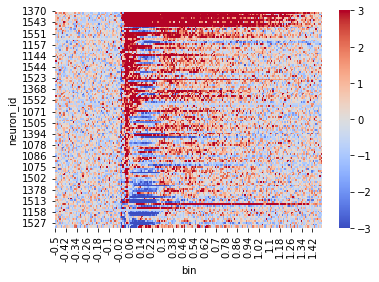

In [78]:
sr = get_group_df(psth, neurons, "sal")
sns.heatmap(sr.transpose(), cmap="coolwarm", vmin=-3, vmax=3)

<AxesSubplot:xlabel='bin', ylabel='neuron_id'>

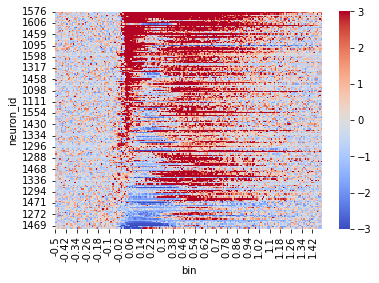

In [79]:
sr = get_group_df(psth, neurons, "continuation")
sns.heatmap(sr.transpose(), cmap="coolwarm", vmin=-3, vmax=3)

<AxesSubplot:xlabel='bin', ylabel='neuron_id'>

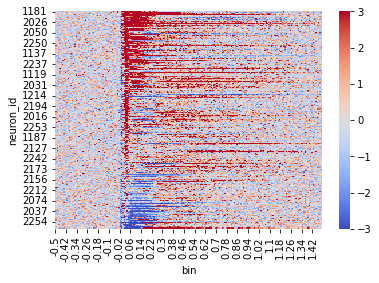

In [80]:
sr = get_group_df(psth, neurons, "discontinuation")
sns.heatmap(sr.transpose(), cmap="coolwarm", vmin=-3, vmax=3)

In [2]:
from spiketimes.df.statistics import ifr_by
from spiketimes.df.binning import binned_spiketrain_bins_provided

In [71]:
# def bin_spikes_regular_intervals(df, binwidth, round_bins=None) -> pd.DataFrame:
#     res =  ifr_by(df, spiketrain_col="neuron_id", fs=1/binwidth)
#     if round_bins is not None:
#         res["time"] = ""

# def bin_spikes():
#     ...

from scipy.ndimage import gaussian_filter1d

def bin_spikes(df, bin_width=0.01, t_before=-0.5, t_max=1.51, spikes_col="spiketimes"):
    bins = np.round(np.arange(t_before, t_max, bin_width), 3)
    return binned_spiketrain_bins_provided(df, 
                                bins=bins, 
                                spiketimes_col=spikes_col, 
                                spiketrain_col="neuron_id")



In [72]:
exlude_using_spike_rate

<function __main__.exlude_using_spike_rate(df, min_rate, baseline_before=None)>

In [100]:
bin_width = 1
pipe = Pipeline([
    (exlude_using_spike_rate, dict(min_rate=0.2, baseline_before=0)),
    (bin_spikes, dict(bin_width=bin_width, t_before=-600, t_max=1200)),
    (counts_to_rate, dict(bin_width=bin_width)),
    (pivot, dict(time_col="bin", value_col="spike_rate")),
    (standardize, dict(baseline_before=0)),
    (gaussian_smooth, dict(sigma=0.5)),
    (sort_by_activity_in_range, dict(t_start=1000, t_stop=1200, agg_func=np.mean)),
])

ramp = pipe.transform(df_all)

<AxesSubplot:xlabel='bin', ylabel='neuron_id'>

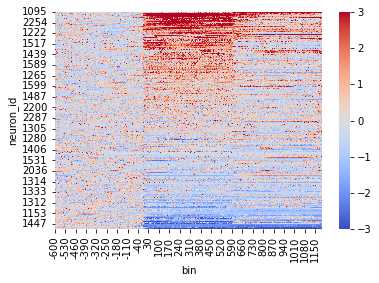

In [101]:
sns.heatmap(ramp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")

In [9]:
from spiketimes.df.binning import binned_spiketrain

binned_spiketrain(post_shock_spikes, spiketimes_col="spiketimes", spiketrain_col="neuron_id", fs=1)

,neuron_id,time,spike_count
0,1069,-599.663833,2
1,1069,-598.663833,3
2,1069,-597.663833,1
3,1069,-596.663833,6
4,1069,-595.663833,3
...,...,...,...
753903,2287,614.193600,3
753904,2287,615.193600,2
753905,2287,616.193600,1
753906,2287,617.193600,1


In [8]:
?binned_spiketrain

Signature:
binned_spiketrain(
    df:pandas.core.frame.DataFrame,
    spiketimes_col:str='spiketimes',
    spiketrain_col:str='spiketrain',
    fs:str=1,
    t_start:float=None,
    t_stop:float=None,
)
Docstring:
Get event counts by entity at regular a constant sampling rate.

Args:
    df: Pandas dataframe containing the data
    fs: Desired sampling frequency in seconds
    spiketimes_col: The label of the column in df containing spiketimes
    spiketrain_col: The label of the column in df containing spiketrain identifiers.
    t_start: The time after which the first bin will start. Default is 0.
    t_stop: The maximum time for the time bins.
Returns:
    A pandas DataFrame containing the binned data. The `time` column contains the left edge of the time bin.
    `spike_count` contains the number of spikes occuring in that bin.
File:      c:\users\roryl\repos\spiketimes\spiketimes\df\binning.py
Type:      function
